In [2]:
%load_ext autoreload
%autoreload 2
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

from m3util.viz.style import set_style
from m3util.viz.layout import layout_fig
from dl_utils.utils.utils import list_to_dict
from dl_utils.utils.dataset import viz_dataloader, split_train_valid, hdf5_dataset
from dl_utils.training.build_model import resnet50_, fpn_resnet50_classification, xcit_small
from dl_utils.analysis.case_analysis import most_confused, prediction_vs_actual
from dl_utils.analysis.attention_map import AttentionMapVisualizer
set_style("printing")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
printing set for seaborn


/home/yichen/Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning/src/m3learning-util/src/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


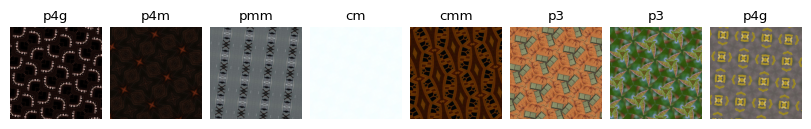

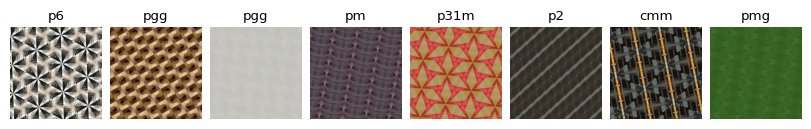

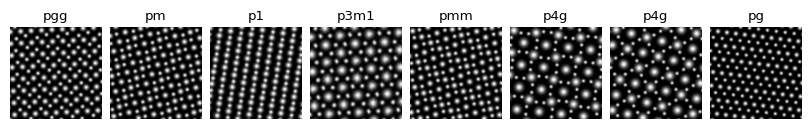

In [5]:
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)

# imagenet
imagenet_ds = hdf5_dataset('../../datasets/imagenet_v5_rot_10m.h5', folder='train', transform=transforms.ToTensor())
train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8)
train_dl = DataLoader(train_ds, batch_size=800, shuffle=True, num_workers=4)
viz_dataloader(train_dl, label_converter=label_converter, title='imagenet - train')
valid_dl = DataLoader(valid_ds, batch_size=800, shuffle=False, num_workers=4)
viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')

# atom
atom_ds = hdf5_dataset('../../datasets/atom_v5_rot_200k.h5', folder='atom', transform=transforms.ToTensor())
atom_dl = DataLoader(atom_ds, batch_size=800, shuffle=False, num_workers=4)
viz_dataloader(atom_dl, label_converter=label_converter, title='atom - cv')

# noise
noise_ds = hdf5_dataset('../../datasets/noise_v5_rot_100k.h5', folder='noise', transform=transforms.ToTensor())
noise_dl = DataLoader(noise_ds, batch_size=800, shuffle=False, num_workers=4)
viz_dataloader(noise_dl, label_converter=label_converter, title='noise - cv')

## Attention Map

In [6]:
visualizer = AttentionMapVisualizer()

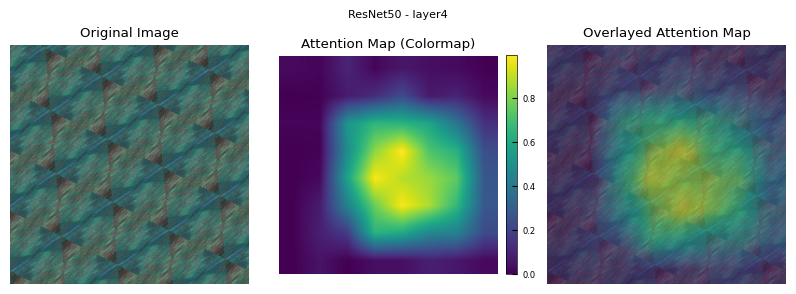

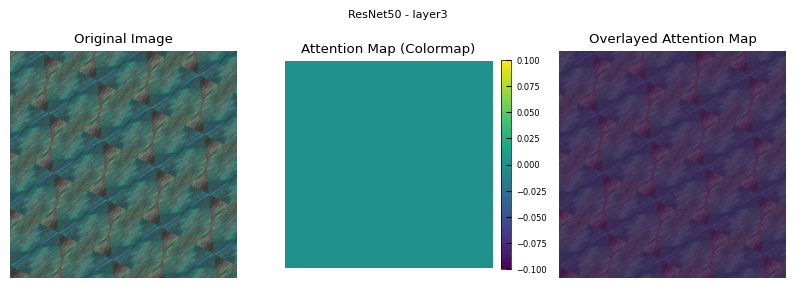

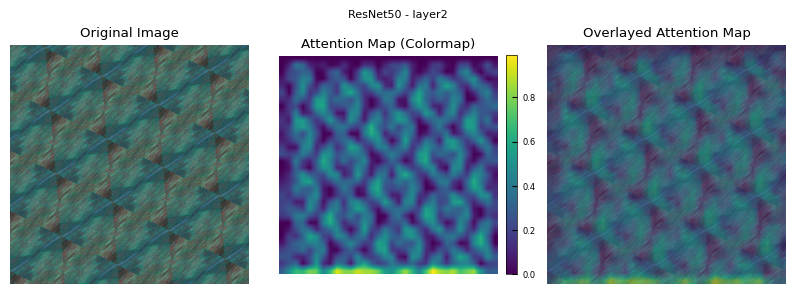

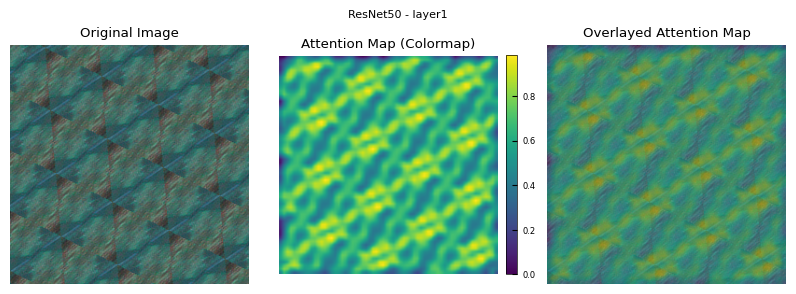

In [10]:
model = resnet50_(in_channels=3, n_classes=len(symmetry_classes))
model.load_state_dict(torch.load('../../models/ResNet50/09112024-resnet50-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True))
model.eval()

input_tensor = train_ds[0][0].unsqueeze(0)  # Example input tensor (N, C, H, W)
for i in ['layer4', 'layer3', 'layer2', 'layer1']:
    input_image_np, attention_map_resized = visualizer.generate_cnn_attention_map(model, input_tensor, layer_name=i)
    visualizer.visualize_attention_map(input_image_np, attention_map_resized, title=f"ResNet50 - {i}")

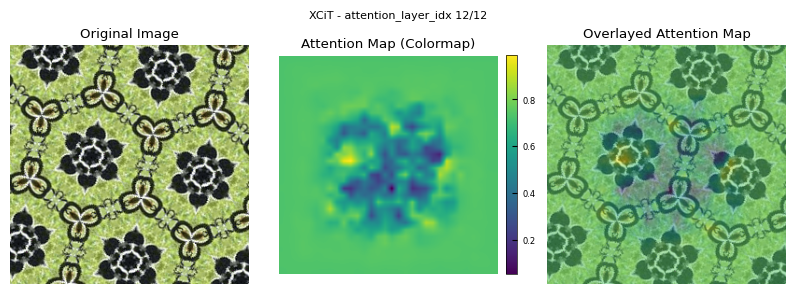

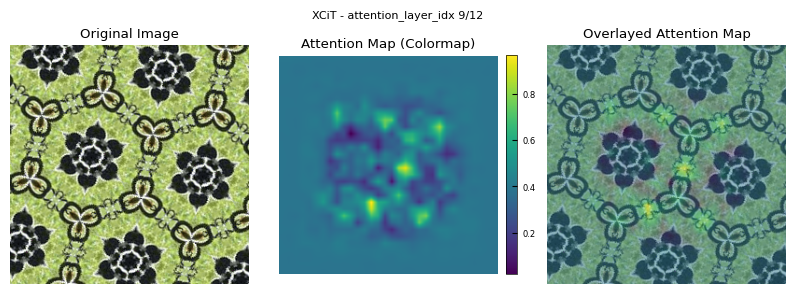

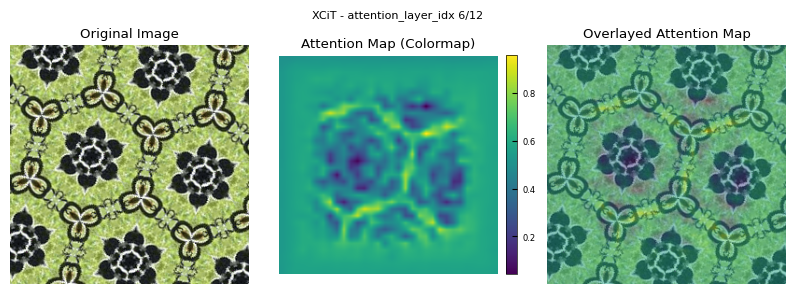

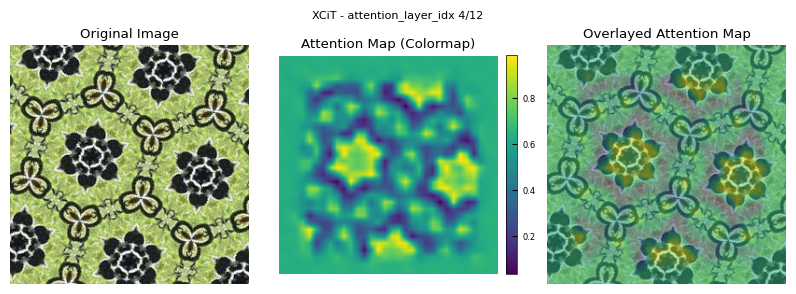

In [11]:
model = xcit_small(in_channels=3, n_classes=len(symmetry_classes))
model.load_state_dict(torch.load('../../models/XCiT/09302024-XCiT-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True))
model.eval()
input_tensor = train_ds[1][0].unsqueeze(0)  # Example input tensor (N, C, H, W)
for i in [11, 8, 5, 3, 0]:
    input_image_np, attention_map_resized = visualizer.generate_transformer_attention_map(model, input_tensor, attention_layer_idx=i)
    visualizer.visualize_attention_map(input_image_np, attention_map_resized, title=f"XCiT - attention_layer_idx {i+1}/12")

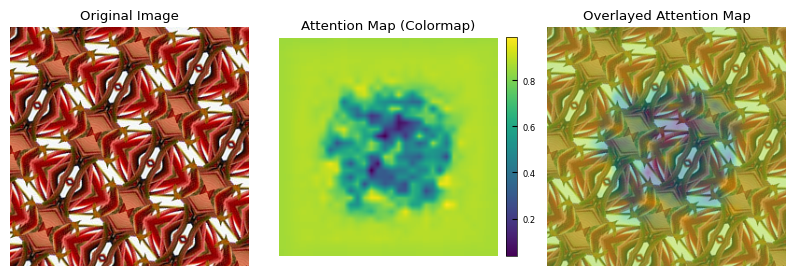

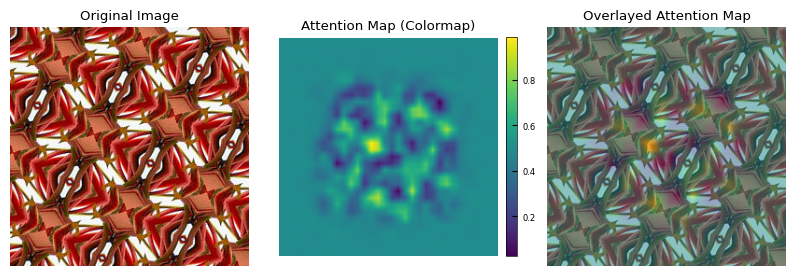

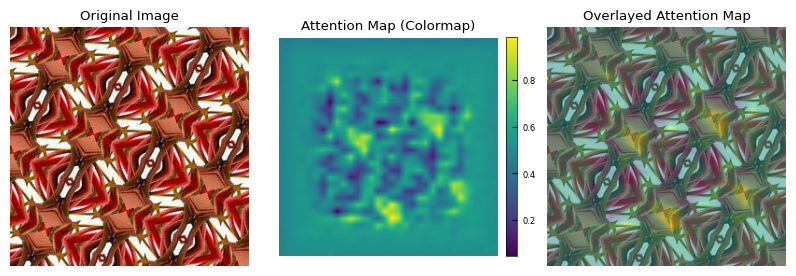

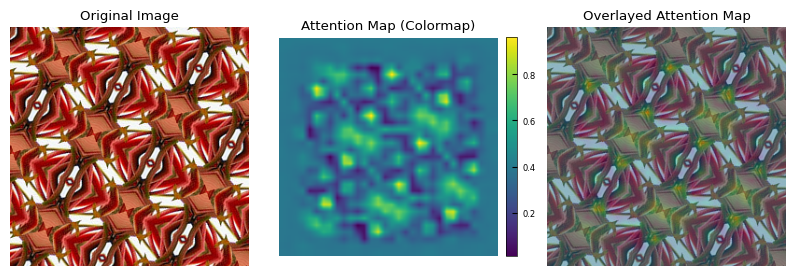

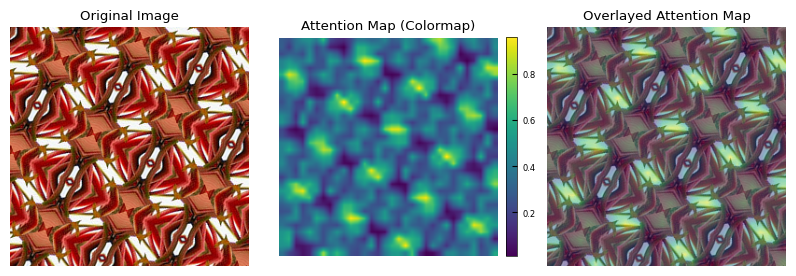

In [44]:
model = xcit_small(in_channels=3, n_classes=len(symmetry_classes))
model.load_state_dict(torch.load('../../../models/XCiT/09302024-XCiT-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True))
model.eval()
input_tensor = train_ds[2][0].unsqueeze(0)  # Example input tensor (N, C, H, W)

for i in [11, 8, 5, 3, 0]:
    attention_map_resized = visualizer.generate_transformer_attention_map(model, input_tensor, attention_layer_idx=i)
    visualizer.visualize_attention_map(input_tensor, attention_map_resized)

In [9]:
attention_map_resized.shape

(256, 256)

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchcam.methods import GradCAM, SmoothGradCAMpp
from torchcam.utils import overlay_mask
from PIL import Image

In [71]:
from PIL import Image
from torchcam.methods import GradCAM
def generate_attention_map(
    model, input_tensor, layer_name="layer4", alpha=0.5, colormap="viridis"
):
    """
    Generates and visualizes an attention map for a given model and input tensor using Grad-CAM.

    Args:
        model (torch.nn.Module): The pre-trained model (ResNet50 or similar).
        input_tensor (torch.Tensor): The input tensor with shape (1, C, H, W).
        layer_name (str): The name of the target layer for Grad-CAM (default: "layer4").
        alpha (float): Transparency for the overlay (default: 0.5).
        colormap (str): Colormap to use for the attention map (default: "viridis").

    Returns:
        None: Displays the original image and its attention map.
    """

    # Ensure the model is in evaluation mode
    model.eval()

    # Initialize Grad-CAM extractor for the specified layer
    cam_extractor = GradCAM(model, layer_name)

    # Forward pass with gradients enabled
    input_tensor.requires_grad = True  # Ensure gradients are tracked for the input
    output = model(input_tensor)

    # Extract the class index with the highest prediction score
    pred_class = output.squeeze(0).argmax().item()

    # Compute the attention map for the predicted class
    attention_map = cam_extractor(pred_class, output)

    # Release Grad-CAM hooks
    cam_extractor.remove_hooks()

    # Convert the input tensor to a PIL image
    input_image = Image.fromarray(
        (input_tensor.squeeze(0).permute(1, 2, 0).detach().numpy() * 255).astype("uint8")
    )
    print(input_image.size)
    
    # Process the attention map for visualization
    attention_map_np = attention_map[0].squeeze().cpu().numpy()  # Ensure it's on the CPU
    attention_map_resized = np.array(
        Image.fromarray(attention_map_np).resize(input_image.size, Image.BILINEAR)
    )
    attention_map_resized = (attention_map_resized - attention_map_resized.min()) / (
        attention_map_resized.max() - attention_map_resized.min()
    )
    print(attention_map_resized.shape)
    
    # Apply the colormap
    cmap = plt.get_cmap(colormap)
    colored_attention_map = cmap(attention_map_resized)[:, :, :3]  # Keep RGB only

    # Create overlay manually
    input_image_np = np.asarray(input_image)
    overlay = (alpha * input_image_np + (1 - alpha) * (colored_attention_map * 255)).astype("uint8")

    # Plot the results with a colorbar
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(input_image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    im = ax[1].imshow(attention_map_resized, cmap=colormap)
    ax[1].set_title("Attention Map (Colormap)")
    ax[1].axis("off")
    fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

    ax[2].imshow(overlay)
    ax[2].set_title("Overlayed Attention Map")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

model = resnet50_(in_channels=3, n_classes=len(symmetry_classes))
model.load_state_dict(torch.load('../../../models/ResNet50/09112024-resnet50-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True))

# Load an example image from your dataset
input_tensor = train_ds[0][0].unsqueeze(0)  # Example input tensor (N, C, H, W)

# Generate the attention map with a colormap
generate_attention_map(model, input_tensor, layer_name="layer4", alpha=0.5, colormap="viridis")

(256, 256)
(256, 256)


In [88]:
def generate_transformer_attention_map(
    model, input_tensor, attention_layer_idx=-1, alpha=0.5, colormap="viridis"
):
    """
    Generates and visualizes attention maps for a transformer model using token-feature embeddings.

    Args:
        model (torch.nn.Module): The transformer model (e.g., XCiT).
        input_tensor (torch.Tensor): The input tensor with shape (1, C, H, W).
        attention_layer_idx (int): Index of the attention layer to visualize (-1 for the last layer).
        alpha (float): Transparency for the overlay (default: 0.5).
        colormap (str): Colormap to use for the attention map (default: "viridis").

    Returns:
        None: Displays the input image and its attention map.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from PIL import Image

    # Ensure the model is in evaluation mode
    model.eval()

    # Hook to capture attention weights
    attention_weights = []

    def hook_fn(module, input, output):
        attention_weights.append(output)

    # Register the hook for the specified attention layer
    layer_to_hook = model.blocks[attention_layer_idx].attn
    hook_handle = layer_to_hook.register_forward_hook(hook_fn)

    # Forward pass through the model
    with torch.no_grad():
        model(input_tensor)

    # Remove the hook after the forward pass
    hook_handle.remove()

    # Check the captured attention weights
    if len(attention_weights) == 0:
        raise ValueError("No attention weights were captured. Check the attention layer indexing.")

    attn_weights = attention_weights[0]  # Shape: (1, 1024, 384)

    # Reshape the attention weights into a spatial map
    tokens = attn_weights.shape[1]  # 1024 tokens
    grid_size = int(tokens**0.5)  # Assume square grid (e.g., 32x32 if 1024 tokens)
    if tokens != grid_size**2:
        raise ValueError(
            f"Number of tokens ({tokens}) cannot be reshaped into a square grid. "
            "Check the model's configuration."
        )

    # Aggregate attention across the embedding dimension (e.g., mean or sum)
    attn_map = attn_weights.mean(dim=-1).squeeze(0).cpu().numpy()  # Shape: (1024,)
    attn_map = attn_map.reshape(grid_size, grid_size)  # Reshape to (Grid, Grid)

    # Normalize the attention map
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    # Resize the attention map to match the input image resolution
    input_image_np = np.asarray(
        (input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255).astype("uint8")
    )
    attention_map_resized = np.array(
        Image.fromarray((attn_map * 255).astype("uint8")).resize(
            input_image_np.shape[:2][::-1], Image.BILINEAR
        )
    ) / 255.0

    # Apply the colormap
    cmap = plt.get_cmap(colormap)
    colored_attention_map = cmap(attention_map_resized)[:, :, :3]  # Keep RGB only

    # Create overlay manually
    colored_attention_map_np = (colored_attention_map * 255).astype("uint8")
    overlay = (
        alpha * input_image_np + (1 - alpha) * colored_attention_map_np
    ).astype("uint8")

    # Plot the results with a colorbar
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(input_image_np)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    im = ax[1].imshow(attn_map, cmap=colormap)
    ax[1].set_title("Attention Map (Colormap)")
    ax[1].axis("off")
    fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

    ax[2].imshow(overlay)
    ax[2].set_title("Overlayed Attention Map")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()
    
model = xcit_small(in_channels=3, n_classes=len(symmetry_classes))
model.load_state_dict(torch.load('../../../models/XCiT/09302024-XCiT-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True))
model.eval

# Load an input image and preprocess
input_tensor = train_ds[0][0].unsqueeze(0)  # Example input tensor (N, C, H, W)

# Generate attention map for the last attention block
generate_transformer_attention_map(model, input_tensor, attention_layer_idx=-1, colormap="viridis")

In [19]:
import torch
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from PIL import Image
import matplotlib.pyplot as plt

# Assuming your custom ResNet50 model is already defined and loaded
# model = ResNet(...)

# Set the model to evaluation mode
model.eval()

# Load an image from your dataset
input_tensor = train_ds[0][0].unsqueeze(0)  # Add batch dimension # shape is N, C, H, W

# Initialize Grad-CAM extractor for the last convolutional layer (layer4)
cam_extractor = GradCAM(model, "layer4")

# Forward pass (ensure gradients are enabled)
output = model(input_tensor)

# Extract the attention map for the predicted class
pred_class = output.squeeze(0).argmax().item()
attention_map = cam_extractor(pred_class, output)

# Release the CAM extractor
cam_extractor.remove_hooks()

In [24]:
input_tensor.shape, attention_map[0].shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 8, 8]))

In [37]:
# Convert the input tensor to a PIL image for visualization
input_image = Image.fromarray((input_tensor.squeeze(0).permute(1, 2, 0).numpy() * 255).astype('uint8'))

# Convert the attention map to a PIL image
attention_map_np = attention_map[0].squeeze().numpy()  # Shape: (H', W')
attention_map_resized = np.array(Image.fromarray(attention_map_np).resize(input_image.size, Image.BILINEAR))  # Resize to (H, W)

# Normalize the attention map to [0, 1] for visualization
attention_map_resized = (attention_map_resized - attention_map_resized.min()) / (attention_map_resized.max() - attention_map_resized.min())

# Convert the resized attention map to a PIL image
attention_map_pil = Image.fromarray((attention_map_resized * 255).astype('uint8'))

# Overlay the attention map on the input image
overlay = overlay_mask(input_image, attention_map_pil, alpha=0.5)

In [ ]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_image)
ax[0].set_title("Original Image")
ax[0].axis("off")

im1 = ax[1].imshow(overlay)
ax[1].set_title("ResNet50 Attention Map")
ax[1].axis("off")
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.show()